In [9]:
import torch
from torch import nn, optim
from tqdm import tqdm
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

%matplotlib inline

In [10]:
class VariationalAutoEncoderModel(nn.Module):
    def __init__(self, latent_dim=10, hidden_dim=64):
        super(VariationalAutoEncoderModel, self).__init__()
        
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flattened_dim = hidden_dim * 7 * 7
        
        self.fc_mu = nn.Linear(self.flattened_dim, latent_dim)
        self.fc_var = nn.Linear(self.flattened_dim, latent_dim)
        
        self.decoder_input = nn.Linear(latent_dim, self.flattened_dim)
        
        self.decoder = torch.nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, 32, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
                
            nn.ConvTranspose2d(16, 1, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, input):
        x = self.encoder(input)
        x = x.view(x.size(0), -1)
        return self.fc_mu(x), self.fc_var(x)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(x.size(0), self.hidden_dim, 7, 7) 
        return self.decoder(x)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def elbo_loss(self, recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD
    
    def sample(self, num_samples, current_device):
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples
        

In [11]:
class VariationalAutoEncoder:
    def __init__(self, loader, epochs=50, learning_rate=0.001, input_size=28):
        pass
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.input_size = input_size
        self.model = VariationalAutoEncoderModel()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_function = self.model.elbo_loss
        self.loader = loader
        
    def train(self):
        outputs = []
        self.losses = []

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)

        for epoch in range(self.epochs):
            with tqdm(self.loader, desc=f"Epoch {epoch+1}/{self.epochs}") as t:
                for images, _ in t:
                    images = images.view(images.size(0), -1, self.input_size, self.input_size).to(device)
                    
                    #def add_noise(image, noise_factor=0.3):
                    #    noise = torch.randn_like(image) * noise_factor
                    #    noisy_image = image + noise
                    #    return torch.clamp(noisy_image, 0., 1.)  
                    #noisy_images = add_noise(images)

                    # Unpack the model's outputs
                    reconstructed, mu, logvar = self.model(images)

                    # Compute the loss
                    loss = self.loss_function(reconstructed, images, mu, logvar)

                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                    self.losses.append(loss.item())
                    
                    t.set_postfix(loss=f"{loss.item():.6f}")

            outputs.append((epoch, images, reconstructed))
        return outputs, self.losses
    
    def show_latent_variation(self, images, device, num_images=6, shift_amount=1.0):
        self.model.eval()
        images = images[:num_images].to(device)

        # Encode the images
        mu, logvar = self.model.encode(images)
        z_original = self.model.reparameterize(mu, logvar)

        # Shift the latent space slightly
        z_shifted = z_original + torch.randn_like(z_original) * shift_amount

        # Decode both original and shifted latent vectors
        recon_original = self.model.decode(z_original)
        recon_shifted = self.model.decode(z_shifted)

        # Convert to NumPy for visualization
        images = images.cpu().detach().numpy()
        recon_original = recon_original.cpu().detach().numpy()
        recon_shifted = recon_shifted.cpu().detach().numpy()

        fig, axes = plt.subplots(3, num_images, figsize=(12, 6))

        for i in range(num_images):
            axes[0, i].imshow(images[i].squeeze(), cmap="gray")
            axes[0, i].axis('off')

            axes[1, i].imshow(recon_original[i].squeeze(), cmap="gray")
            axes[1, i].axis('off')

            axes[2, i].imshow(recon_shifted[i].squeeze(), cmap="gray")
            axes[2, i].axis('off')

        axes[0, 0].set_title("Original Images")
        axes[1, 0].set_title("Reconstructed")
        axes[2, 0].set_title("Latent Shifted")

        plt.show()
        
    def plot_loss(self):
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(4, 2))
        plt.plot(self.losses[1:], label='Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [12]:
loader = torch.utils.data.DataLoader(
            datasets.MNIST('../data', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor()
                           ])),
            batch_size=64, shuffle=True)
mnist_vae = VariationalAutoEncoder(loader)

outputs, losses = mnist_vae.train()
mnist_vae.plot_loss()

Epoch 1/50:  54%|█████▍    | 511/938 [00:07<00:06, 67.69it/s, loss=6725.611328] 


KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_vae.show_latent_variation( outputs[-1][1], device, num_images=6, shift_amount=1.0)

NameError: name 'outputs' is not defined

# Recommendation

In [13]:
class VAERecModel(nn.Module):
    def __init__(self, num_items, latent_dim=10, hidden_dim=64, dropout=0.2):
        super(VAERecModel, self).__init__()
        
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        
        self.encoder = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_items, hidden_dim*2),
            nn.ReLU(),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # Output both mu and logvar
        )
        self.fc_mu = nn.Linear(latent_dim * 2, latent_dim)
        self.fc_var = nn.Linear(latent_dim * 2, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.ReLU(),
            nn.Linear(hidden_dim*2, num_items),
            nn.Sigmoid()  # Output is between 0 and 1 (probability of liking an item)
        )
        
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        return self.fc_mu(x), self.fc_var(x)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def elbo_loss(self, recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD
    
    def sample(self, num_samples, current_device):
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples
        

In [14]:
class RecommenderDataset(data.Dataset):
    """Custom Dataset to handle User-Item Interactions"""
    def __init__(self, user_item_matrix):
        self.data = torch.FloatTensor(user_item_matrix)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
class VAERecommenderSystem:
    def __init__(self, user_item_matrix, latent_dim=64, hidden_dim=256, batch_size=1, lr=0.001, epochs=56, val_split=0.2):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_items = user_item_matrix.shape[1]
        self.model = VAERecModel(self.num_items, latent_dim, hidden_dim).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.epochs = epochs

        # Split into train and validation sets
        train_data, val_data = train_test_split(user_item_matrix, test_size=val_split, random_state=42)

        # Prepare dataset loaders
        self.train_dataset = RecommenderDataset(train_data)
        self.val_dataset = RecommenderDataset(val_data)

        self.train_loader = data.DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        self.val_loader = data.DataLoader(self.val_dataset, batch_size=batch_size, shuffle=False)

        # Store loss history
        self.train_losses = []
        self.val_losses = []

    def train(self):
        print("Training started...")
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0
            
            for batch in self.train_loader:
                batch = batch.to(self.device)
                self.optimizer.zero_grad()

                # Forward pass
                recon_batch, mu, logvar = self.model(batch)
                loss = self.model.elbo_loss(recon_batch, batch, mu, logvar)

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

            avg_train_loss = train_loss / len(self.train_loader)
            self.train_losses.append(avg_train_loss)

            # Validation Step
            val_loss = self.validate()
            self.val_losses.append(val_loss)

            print(f"Epoch {epoch+1}/{self.epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

    def validate(self):
        self.model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in self.val_loader:
                batch = batch.to(self.device)
                recon_batch, mu, logvar = self.model(batch)
                loss = self.model.elbo_loss(recon_batch, batch, mu, logvar)
                val_loss += loss.item()

        return val_loss / len(self.val_loader)

    def plot_loss(self):
        plt.plot(self.train_losses, label="Train Loss")
        plt.plot(self.val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    def predict(self, user_vector):
        """Given a user's interaction vector, return top-K recommended items."""
        self.model.eval()
        user_vector = torch.FloatTensor(user_vector).unsqueeze(0).to(self.device)

        with torch.no_grad():
            mu, logvar = self.model.encode(user_vector)
            z = self.model.reparameterize(mu, logvar)
            predictions = self.model.decode(z)
            
        return predictions

    
    def recommend_items(self, user_data, user_idx=None, top_k=10, exclude_known=True):
        if user_idx is not None:
            user_vector = user_data[user_idx].unsqueeze(0)
        else:
            user_vector = user_data
            
        predictions = self.predict(user_vector).squeeze().cpu().numpy()
        
        if exclude_known and user_idx is not None:
            known_items = user_data[user_idx].cpu().numpy() > 0
            predictions[known_items] = -float('inf')
        
        top_items = np.argsort(predictions)[::-1][:top_k]
        return [(item_idx, predictions[item_idx]) for item_idx in top_items]
        
    def latent_space_variation(self, user_vector, shift_amount=1.0):
        """Shift latent space and see how recommendations change"""
        self.model.eval()
        user_vector = torch.FloatTensor(user_vector).unsqueeze(0).to(self.device)

        with torch.no_grad():
            mu, logvar = self.model.encode(user_vector)
            z_original = self.model.reparameterize(mu, logvar)
            z_shifted = z_original + torch.randn_like(z_original) * shift_amount

            recon_original = self.model.decode(z_original).cpu().detach().numpy().flatten()
            recon_shifted = self.model.decode(z_shifted).cpu().detach().numpy().flatten()

        return np.argsort(recon_original)[::-1][:5], np.argsort(recon_shifted)[::-1][:5]

In [16]:
# Load the Dataset
df = pd.read_csv('data/lfm_interactions.csv', sep="\t", index_col=0)
inter_matr = pd.pivot_table(df, values='count', index='user_id', columns='item_id')
inter_matr = inter_matr.fillna(0).to_numpy()
inter_matr = (inter_matr > 0).astype(int)

inter_tensor = torch.FloatTensor(inter_matr)

Training started...
Epoch 1/56 - Train Loss: 228.5692 | Val Loss: 212.0929
Epoch 2/56 - Train Loss: 203.7279 | Val Loss: 199.2943
Epoch 3/56 - Train Loss: 201.0222 | Val Loss: 193.0032
Epoch 4/56 - Train Loss: 197.8888 | Val Loss: 192.2014
Epoch 5/56 - Train Loss: 195.9290 | Val Loss: 190.4891
Epoch 6/56 - Train Loss: 194.9237 | Val Loss: 190.5222
Epoch 7/56 - Train Loss: 194.5668 | Val Loss: 191.9749
Epoch 8/56 - Train Loss: 193.5858 | Val Loss: 188.8634
Epoch 9/56 - Train Loss: 189.2968 | Val Loss: 183.1795
Epoch 10/56 - Train Loss: 190.4883 | Val Loss: 181.6848
Epoch 11/56 - Train Loss: 182.7434 | Val Loss: 181.5257
Epoch 12/56 - Train Loss: 193.2898 | Val Loss: 182.2875
Epoch 13/56 - Train Loss: 179.2269 | Val Loss: 178.4523
Epoch 14/56 - Train Loss: 200.2366 | Val Loss: 175.2343
Epoch 15/56 - Train Loss: 55827.2095 | Val Loss: 173.3604
Epoch 16/56 - Train Loss: 191.8128 | Val Loss: 173.0525
Epoch 17/56 - Train Loss: 172.8743 | Val Loss: 172.1817
Epoch 18/56 - Train Loss: 172.4470 

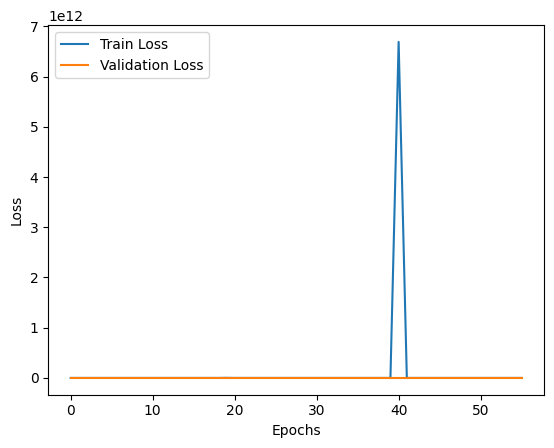

In [17]:
vae_recommender = VAERecommenderSystem(inter_tensor, latent_dim=64, epochs=56, val_split=0.25)
vae_recommender.train()
vae_recommender.plot_loss()

In [18]:
ids = pd.read_csv('evaluation-data/test_users.txt')
user_recommendations = []

for id in ids.user_id:
    recommendation = vae_recommender.recommend_items(inter_tensor, id, top_k=10)
    item_ids = [str(item_id) for item_id, _ in recommendation]
    user_recommendations.append([id, ','.join(item_ids)])

df = pd.DataFrame(user_recommendations, columns=['user_id', 'recommendations'])

df.to_csv('res/rec_vae.tsv', index=False, sep='\t', header=False)